<!--NOTEBOOK_HEADER-->
*This notebook contains material from [CBE40455-2020](https://jckantor.github.io/CBE40455-2020);
content is available [on Github](https://github.com/jckantor/CBE40455-2020.git).*


<!--NAVIGATION-->
< [3.3 Agent Based Models](https://jckantor.github.io/CBE40455-2020/03.03-Agent-Based-Models.html) | [Contents](toc.html) | [3.10 Agent based model for control of COVID-19 on a college campus](https://jckantor.github.io/CBE40455-2020/03.10-Agent-based-campus-covid-model.html)<p><a href="https://colab.research.google.com/github/jckantor/CBE40455-2020/blob/master/docs/03.04-Modeling-Events.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/CBE40455-2020/03.04-Modeling-Events.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 3.4 Modeling Events

## 3.4.1 Learning Objectives

* Key performance indicators
* Visualization with Gannt charts
* Adding 'state' to our models
* Deterministic versus stochastic models
* Queuing Models (if time)

## 3.4.2 Example: A room full of Roombas

Let's imagine a large facility that is being cleaned by a collection of Roomba-type robotic cleaning units.  Each unit is characterized by time required to charge, and an amount of time it can clean before needing to be recharged. The facility must be cleaned during a 16 hour overnight shift. On average, 3 units must be operating continuously to meet the cleaning requirements, i.e., 3 x 16 = 48 hours machine cleaning each night. We would like to determine how many charging stations will be required.

| Unit | Charge Time (hrs) | Clean Time (hrs) |
| :--: | :--: | :--: |
| A | 1.0 | 2.5 |
| B | 0.5 | 1.5 |
| C | 0.8 | 2.0 |
| D | 1.4 | 3.5 |
| E | 0.5 | 1.2 |

## 3.4.3 Model of agents sharing a resource

### 3.4.3.1 Installation, Import, and Setup section

In [109]:
# necessary installations
!pip install simpy

# import section
import simpy 
import pandas as pd
import numpy as np

### 3.4.3.2 Data section

In [110]:
# data section

roomba_data = [
    ["A", 1.0, 2.5],
    ["B", 0.5, 1.5],
    ["C", 0.8, 2.0],
    ["D", 1.4, 3.5],
    ["E", 0.5, 1.2],
]

roomba_df = pd.DataFrame(roomba_data, columns=["id", "charge_time", "clean_time"])
display(roomba_df)

,id,charge_time,clean_time
0,A,1.0,2.5
1,B,0.5,1.5
2,C,0.8,2.0
3,D,1.4,3.5
4,E,0.5,1.2


### 3.4.3.3 Modeling and simulation section

The output of the modeling and simulation is a Pandas DataFrame giving a complete history of the events occuring during a simulation.

In [111]:
def roomba_model(id, charge_time, clean_time):
    while True:
        with chargers.request() as request:
            yield request
            tic = env.now
            yield env.timeout(charge_time)
            toc = env.now
            data_log.append([id, "charging", tic, toc])
            
        tic = env.now
        yield env.timeout(clean_time)
        toc = env.now
        data_log.append([id, "cleaning", tic, toc])

data_log = []

env = simpy.Environment()
chargers = simpy.Resource(env, capacity=1)
for r in roomba_df.index:
    env.process(roomba_model(roomba_df["id"][r], roomba_df["charge_time"][r], roomba_df["clean_time"][r]))
env.run(until=16)

df = pd.DataFrame(data_log, columns=["id", "event", "begin", "end"])
df.head()

,id,event,begin,end
0,A,charging,0.0,1.0
1,B,charging,1.0,1.5
2,C,charging,1.5,2.3
3,B,cleaning,1.5,3.0
4,A,cleaning,1.0,3.5


### 3.4.3.4 Key performance indictors

Key Performance Indicators (KPI) is a commonly used termed to denote quantitative measures important to the performance of an organization, unit, or system.

In [112]:
def kpi(df):
    df["time"] = df["end"] - df["begin"]
    return pd.pivot_table(df, index=["event"], values="time", aggfunc={"time":np.sum} )
    
kpi(df)

,time
event,
charging,15.4
cleaning,31.3


### 3.4.3.5 Visualization with Gantt charts

Designed circa 1910-1915 by Henry Gantt, an American mechanical engineer who worked with Frederick W. Taylor, one of the first management consultants and a leader in the Efficiency Movement of the late 19th century.

Gantt charts provide a convenient method to display complex schedules and the time-dependent allocation of resources.

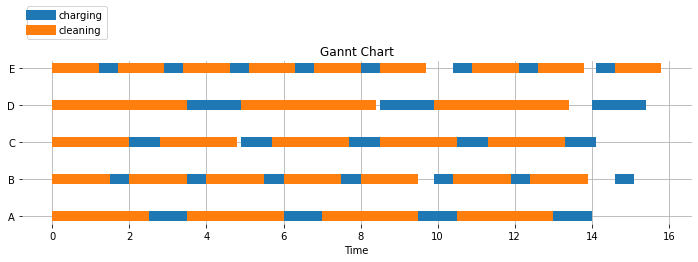

In [118]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def gantt(df, lw=10):
    
    # create sorted lists of the unique ids and events appearing in the data log
    ids = sorted(list(set(df["id"])))
    events = sorted(list(set(df["event"])))
    
    # create list of unique colors for each event
    colors = [f"C{i}" for i in range(len(events))]
    
    # create plot window
    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    
    # for each event and id, find entries in the data log and plot the begin and end points
    for i, event in enumerate(events):
        for j, id in enumerate(ids):  
            for k in df[(df["id"]==id) & (df["event"]==event)].index:
                ax.plot([df["begin"][k], df["end"][k]], [j,j], 
                        colors[i], solid_capstyle="butt", lw=lw)
                
    # create legend
    lines = [Line2D([0], [0], lw=lw, color=colors[i]) for i in range(len(events))]
    ax.legend(lines, events, bbox_to_anchor=(0.0, 1.1), loc="lower left")
    
    # annotate the axes
    ax.set_yticks(range(len(ids)))
    ax.set_yticklabels(ids)
    ax.grid(True)
    ax.set_xlabel("Time")
    ax.set_title("Gannt Chart")
    for sp in ['top', 'bottom', 'right', 'left']:
        ax.spines[sp].set_visible(False)
        
gantt(df)

## 3.4.4 Assignment Review

### 3.4.4.1 Exercise 1. 

Answer the question posed above: How many charging stations are needed to provide 48 hours cleaning services in the overnight shift?

#### 3.4.4.1.1 Solution

,time
event,
charging,19.7
cleaning,51.8


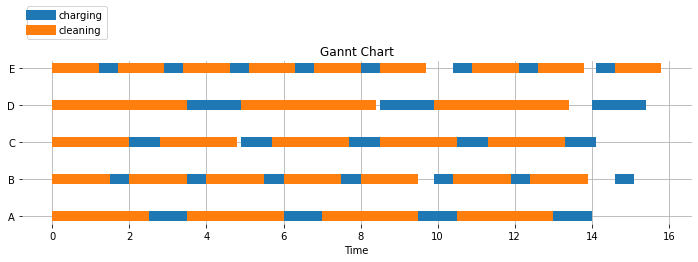

In [119]:
data_log = []

env = simpy.Environment()
chargers = simpy.Resource(env, capacity=2)
for r in roomba_df.index:
    env.process(roomba_model(roomba_df["id"][r], roomba_df["charge_time"][r], roomba_df["clean_time"][r]))
env.run(until=16)

df = pd.DataFrame(data_log, columns=["id", "event", "begin", "end"])
display(kpi(df))
gantt(df)

We see that two chargers are sufficient to meet the performance requirement. But keep in mind there has been no deliberate strategy for allocating the chargers. The Roombas simply wait in line when they need access. There may be better ways to allocate a scare resource than first-come, first-serve.

### 3.4.4.2 Exercise 2.

Modify the model to assume the changers are fully charged at the start of the cleaning shift. Does that reduce the number of chargers required?

#### 3.4.4.2.1 Solution

,time
event,
charging,19.7
cleaning,51.8


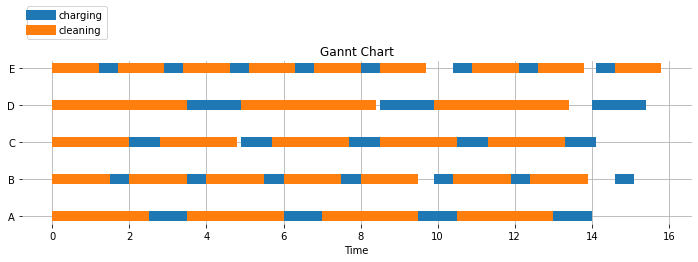

In [120]:
def roomba_model(id, charge_time, clean_time):
    while True:
        tic = env.now
        yield env.timeout(clean_time)
        toc = env.now
        data_log.append([id, "cleaning", tic, toc])
        with chargers.request() as request:
            yield request
            tic = env.now
            yield env.timeout(charge_time)
            toc = env.now
            data_log.append([id, "charging", tic, toc])
            
data_log = []

env = simpy.Environment()
chargers = simpy.Resource(env, capacity=2)
for r in roomba_df.index:
    env.process(roomba_model(roomba_df["id"][r], roomba_df["charge_time"][r], roomba_df["clean_time"][r]))
env.run(until=16)

df = pd.DataFrame(data_log, columns=["id", "event", "begin", "end"])
display(kpi(df))
gantt(df)

#### 3.4.4.2.2 A second solution using state of charge

The solution to this exercise can be generalized by introducing a state variable `soc` denoting the 'state of charge'. The state of charge is the fraction of charge remaining in the device battery. The state of charge is reduced during cleaning operations, and restored during charging operation, in proportion to the time spent cleaning and charging, respectively.

Given an initial full charge, let parameter $\tau_{clean}$ denote the maximum time the device can clean before completely exhausting the battery. Let $\text{SOC}_{k}$ be the state of charge after the $k_{th}$ cleaning cycle. Then

$$\text{SOC}_{k+1} = \max(0, \text{SOC}_k - \frac{t_{k, clean}}{\tau_{clean}})$$

where $t_{k,clean}$ is the period of the $k_{th}$ cleaning cycle.

An additional parameter is introduced to represent the minimum battery reserve that would be allowed for normal operations.

Similarly, the state of charge following a charging cycle is given by

$$\text{SOC}_{k+1} = \min(1, \text{SOC}_k + \frac{t_{k, charge}}{\tau_{charge}})$$

It is interesting to explore the behavior of this system as a function of the initial state of charge and reserve requirements. Take time to explore the role of these two parameters. See if you find any surprising behaviors.

,time
event,
charging,14.31
cleaning,43.11


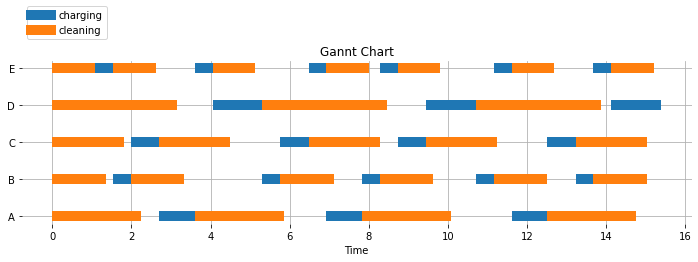

In [126]:
def roomba_model(id, charge_time, clean_time, reserve=0.1):
    soc = 1.0   # state of charge
    while True:
        if soc > reserve:
            tic = env.now
            yield env.timeout((soc - reserve) * clean_time)
            toc = env.now
            soc = max(0.0, soc - (toc - tic)/clean_time)
            data_log.append([id, "cleaning", tic, toc])
            
        with chargers.request() as request:
            yield request
            tic = env.now
            yield env.timeout((1 - soc)*charge_time)
            toc = env.now
            soc = min(1.0, soc + (toc - tic)/charge_time)
            data_log.append([id, "charging", tic, toc])
            
data_log = []

env = simpy.Environment()
chargers = simpy.Resource(env, capacity=1)
for r in roomba_df.index:
    env.process(roomba_model(roomba_df["id"][r], roomba_df["charge_time"][r], roomba_df["clean_time"][r]))
env.run(until=16)

df = pd.DataFrame(data_log, columns=["id", "event", "begin", "end"])
display(kpi(df))
gantt(df)

### 3.4.4.3 Exercise 3.

Assume each Roomba needs to dispose of waste after 20 minutes of cleaning, that it takes 5 minutes to dispose of the waste, and requires access to a waste disposal station. 

Hints:
* You will need to create a log a new event called 'waste disposal'. 
* Model the waste disposal station as a shared resource.
* You may need to make some decisions on how to handle the waste at the end of a cleaning cycle. Don't get too bogged down, just make some reasonable assumptions. We'll address this issue in the next class. 

,time
event,
charging,16.470000
cleaning,48.503333
waste disposal,12.083333


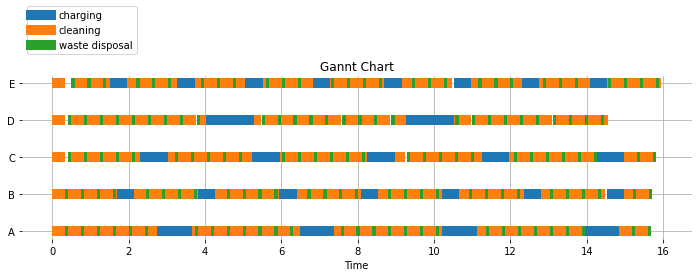

In [127]:
five_min = 1.0/12.0
twenty_min = 1.0/3.0

def roomba_model(id, charge_time, clean_time, reserve=0.1):
    soc = 1.0   # state of charge
    sow = 0.0   # state of waste
    while True:
        if soc > reserve and sow < 1.0:
            tic = env.now
            yield simpy.events.AnyOf(env, [env.timeout((soc - reserve) * clean_time), env.timeout((1.0 - sow)*twenty_min)])
            toc = env.now
            soc = max(0.0, soc - (toc - tic)/clean_time)
            sow = min(1.0, sow + (toc - tic)/twenty_min)
            data_log.append([id, "cleaning", tic, toc])
        if sow >= 1.0 - 0.001:
            with waste_stations.request() as request:
                yield request
                tic = env.now
                yield env.timeout(five_min)
                toc = env.now
                sow = 0.0
                data_log.append([id, "waste disposal", tic, toc])
        if soc <= reserve+ 0.001:
            with chargers.request() as request:
                yield request
                tic = env.now
                yield env.timeout((1 - soc)*charge_time)
                toc = env.now
                soc = min(1.0, soc + (toc - tic)/charge_time)
                data_log.append([id, "charging", tic, toc])
           
data_log = []

env = simpy.Environment()
chargers = simpy.Resource(env, capacity=3)
waste_stations = simpy.Resource(env, capacity=2)
for r in roomba_df.index:
    env.process(roomba_model(roomba_df["id"][r], roomba_df["charge_time"][r], roomba_df["clean_time"][r]))
env.run(until=16)

df = pd.DataFrame(data_log, columns=["id", "event", "begin", "end"])
display(kpi(df))
gantt(df)

## 3.4.5 Modeling random behavior

,time
event,
charging,17.730000
cleaning,49.337251
waste disposal,11.250000


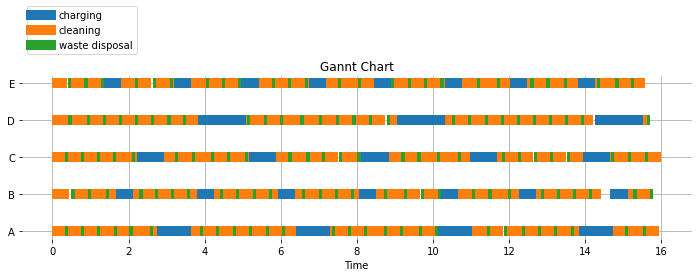

In [128]:
import random

five_min = 5.0/60.0
ten_min = 10.0/60.0
twenty_min = 20.0/60.0
thirty_min = 30.0/60.0

def roomba_model(id, charge_time, clean_time, reserve=0.1):
    soc = 1.0   # state of charge
    sow = 0.0   # state of waste
    while True:
        if soc > reserve and sow < 1.0:
            tic = env.now
            yield simpy.events.AnyOf(env, [env.timeout((soc - reserve) * clean_time), 
                                           env.timeout((1.0 - sow)*random.triangular(ten_min, thirty_min))])
            toc = env.now
            soc = max(0.0, soc - (toc - tic)/clean_time)
            sow = min(1.0, sow + (toc - tic)/twenty_min)
            data_log.append([id, "cleaning", tic, toc])
        if sow >= 1.0 - 0.001:
            with waste_stations.request() as request:
                yield request
                tic = env.now
                yield env.timeout(five_min)
                toc = env.now
                sow = 0.0
                data_log.append([id, "waste disposal", tic, toc])
        if soc <= reserve+ 0.001:
            with chargers.request() as request:
                yield request
                tic = env.now
                yield env.timeout((1 - soc)*charge_time)
                toc = env.now
                soc = min(1.0, soc + (toc - tic)/charge_time)
                data_log.append([id, "charging", tic, toc])
           
data_log = []

env = simpy.Environment()
chargers = simpy.Resource(env, capacity=3)
waste_stations = simpy.Resource(env, capacity=2)
for r in roomba_df.index:
    env.process(roomba_model(roomba_df["id"][r], roomba_df["charge_time"][r], roomba_df["clean_time"][r]))
env.run(until=16)

df = pd.DataFrame(data_log, columns=["id", "event", "begin", "end"])
display(kpi(df))
gantt(df)

mean = 47.96
std = 0.31


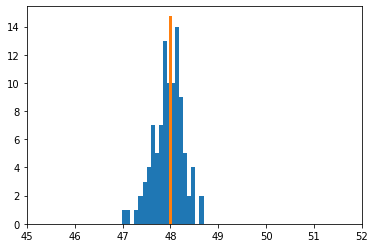

In [129]:
import random

five_min = 5.0/60.0
ten_min = 10.0/60.0
twenty_min = 20.0/60.0
thirty_min = 30.0/60.0

def roomba_model(id, charge_time, clean_time, reserve=0.1):
    soc = 1.0   # state of charge
    sow = 0.0   # state of waste
    while True:
        if soc > reserve and sow < 1.0:
            tic = env.now
            yield simpy.events.AnyOf(env, [env.timeout((soc - reserve) * clean_time), 
                                           env.timeout((1.0 - sow)*random.triangular(ten_min, thirty_min))])
            toc = env.now
            soc = max(0.0, soc - (toc - tic)/clean_time)
            sow = min(1.0, sow + (toc - tic)/twenty_min)
            data_log.append([id, "cleaning", tic, toc])
        if sow >= 1.0 - 0.001:
            with waste_stations.request() as request:
                yield request
                tic = env.now
                yield env.timeout(five_min)
                toc = env.now
                sow = 0.0
                data_log.append([id, "waste disposal", tic, toc])
        if soc <= reserve+ 0.001:
            with chargers.request() as request:
                yield request
                tic = env.now
                yield env.timeout((1 - soc)*charge_time)
                toc = env.now
                soc = min(1.0, soc + (toc - tic)/charge_time)
                data_log.append([id, "charging", tic, toc])
    
y = []
N = 10000
for k in range(100):
    data_log = []

    env = simpy.Environment()
    chargers = simpy.Resource(env, capacity=2)
    waste_stations = simpy.Resource(env, capacity=2)
    for r in roomba_df.index:
        env.process(roomba_model(roomba_df["id"][r], roomba_df["charge_time"][r], roomba_df["clean_time"][r]))
    env.run(until=16)

    df = pd.DataFrame(data_log, columns=["id", "event", "begin", "end"])
    y.append(kpi(df)["time"]["cleaning"])

y = np.array(y)
plt.hist(y, bins=20)
plt.xlim(45.0, 52.0)
plt.plot([48,48], plt.ylim(), lw=3)
print("mean =", round(y.mean(), 2))
print("std =", round(y.std(), 2))

## 3.4.6 Lots of Roombas

,time
event,
charging,32.939826
cleaning,95.748237
waste disposal,22.083333


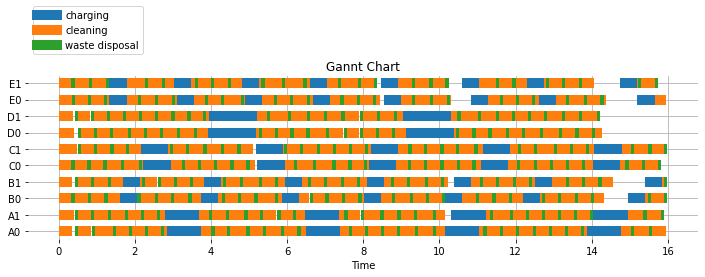

In [131]:
import random

five_min = 5.0/60.0
ten_min = 10.0/60.0
twenty_min = 20.0/60.0
thirty_min = 30.0/60.0

def roomba_model(id, charge_time, clean_time, reserve=0.1):
    soc = 1.0   # state of charge
    sow = 0.0   # state of waste
    while True:
        if soc > reserve and sow < 1.0:
            tic = env.now
            yield simpy.events.AnyOf(env, [env.timeout((soc - reserve) * clean_time), 
                                           env.timeout((1.0 - sow)*random.triangular(ten_min, thirty_min))])
            toc = env.now
            soc = max(0.0, soc - (toc - tic)/clean_time)
            sow = min(1.0, sow + (toc - tic)/twenty_min)
            data_log.append([id, "cleaning", tic, toc])
        if sow >= 1.0 - 0.001:
            with waste_stations.request() as request:
                yield request
                tic = env.now
                yield env.timeout(five_min)
                toc = env.now
                sow = 0.0
                data_log.append([id, "waste disposal", tic, toc])
        if soc <= reserve+ 0.001:
            with chargers.request() as request:
                yield request
                tic = env.now
                yield env.timeout((1 - soc)*charge_time)
                toc = env.now
                soc = min(1.0, soc + (toc - tic)/charge_time)
                data_log.append([id, "charging", tic, toc])
           
data_log = []

env = simpy.Environment()
chargers = simpy.Resource(env, capacity=4)
waste_stations = simpy.Resource(env, capacity=4)
for k in range(2):
    for r in roomba_df.index:
        env.process(roomba_model(roomba_df["id"][r] + str(k), roomba_df["charge_time"][r], roomba_df["clean_time"][r]))
env.run(until=16)

df = pd.DataFrame(data_log, columns=["id", "event", "begin", "end"])
display(kpi(df))
gantt(df)

## 3.4.7 Assignment (to be submitted Thursday, Sept. 3rd).

The facility has expanded to an average of 100 hours of machine cleaning time are required during the 16 hour overnight shift. The company would like to settle on a single cleaning model rather than servicing five different models. 

Modify the above model to determine the the model (A, B, C, D, or E) and number of devices required to meet the service requirement.

<!--NAVIGATION-->
< [3.3 Agent Based Models](https://jckantor.github.io/CBE40455-2020/03.03-Agent-Based-Models.html) | [Contents](toc.html) | [3.10 Agent based model for control of COVID-19 on a college campus](https://jckantor.github.io/CBE40455-2020/03.10-Agent-based-campus-covid-model.html)<p><a href="https://colab.research.google.com/github/jckantor/CBE40455-2020/blob/master/docs/03.04-Modeling-Events.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/CBE40455-2020/03.04-Modeling-Events.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>